<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

### Import Libraries

In [18]:
#!pip install optuna-integration

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone

# Feature Selection
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics and Utilities
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss
from sklearn.model_selection import ParameterGrid


### Load Data

In [20]:
# Load the processed datasets (train, validation, test)
X_train = pd.read_parquet("./project_data/X_train_final.parquet", engine="pyarrow")
X_val   = pd.read_parquet("./project_data/X_val_final.parquet",   engine="pyarrow")
X_test  = pd.read_parquet("./project_data/X_test_final.parquet",  engine="pyarrow")

y_train_df = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val_df   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set 'carID' as the index for all sets
X_train.set_index('carID', inplace=True)
X_val.set_index('carID', inplace=True)
X_test.set_index('carID', inplace=True)

# Extract the target variable 'price' as a Series and ensure its index is 'carID'
y_train = y_train_df.set_index('carID')['price']
y_val = y_val_df.set_index('carID')['price']

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (60763, 37)
Shape of y_train: (60763,)
Shape of X_val: (15193, 37)
Shape of y_val: (15193,)
Shape of X_test: (32567, 37)


In [21]:
X_train.columns

Index(['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'age', 'miles_per_year',
       'brand_mean_price', 'brand_median_price', 'brand_price_std',
       'brand_count', 'mileage_per_year', 'high_mileage', 'low_mileage',
       'age_squared', 'is_new_car', 'is_old_car', 'mpg_per_liter',
       'engine_power_indicator', 'age_mileage_interaction',
       'depreciation_score', 'tax_per_engine', 'Brand_target_enc',
       'brand_model_target_enc', 'transmission_manual', 'transmission_other',
       'transmission_semi auto', 'transmission_unknown', 'fuelType_electric',
       'fuelType_hybrid', 'fuelType_other', 'fuelType_petrol',
       'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range'],
      dtype='object')

<div style="background-color:#644712c5; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2.11 | Feature Selection</b></span>
    </h1>
</div>

We applied several Feature Selection techniques (including *Filter Methods*, *Wrapper Methods*, and *Embedded Methods*) to identify and remove **irrelevant** or **highly correlated** variables, reducing dimensionality and improving the model’s performance and interpretability.

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods</b></span>
    </h1>
</div>

##### **Variance Threshold**

In [22]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train)

# Get low variance columns and print them
low_variance = X_train.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train.columns.get_loc(col)]:.4f}")

Number of features with variance closer to zero: 1
Features with variance closer to zero:
hasDamage: 0.0000


We had already observed that the **`hasDamage`** variable was not particularly relevant. During imputation, all its non-null values were zeros, resulting in the variable being zero for every observation. This means it provides no useful information and can therefore be safely removed. Similarly, the variables **`transmission_other`**, **`fuelType_electric`**, and **`fuelType_other`** were also discarded, as they are almost always zero. These features were created through one-hot encoding and represent very rare categories, resulting in **near-zero variance** and minimal contribution to the model.

In [23]:
# Drop low variance columns from train, val and test sets
for d in [X_train, X_val , X_test]:
    d = d.drop(columns=low_variance, errors='ignore', inplace=True)

##### **Correlation Indices**

We chose to use **Spearman correlation** because, unlike Pearson, it can handle **non-linear relationships** and is **less sensitive to outliers**, which fits our data. Spearman measures how well the relationship between two variables can be described by a **monotonic** trend

In [24]:
# Identify non-binary columns in X_train
non_binary_cols = X_train.columns[X_train.nunique() > 2]

# Create a filtered DataFrame with only non-binary columns
X_train_filtered = X_train[non_binary_cols].copy()

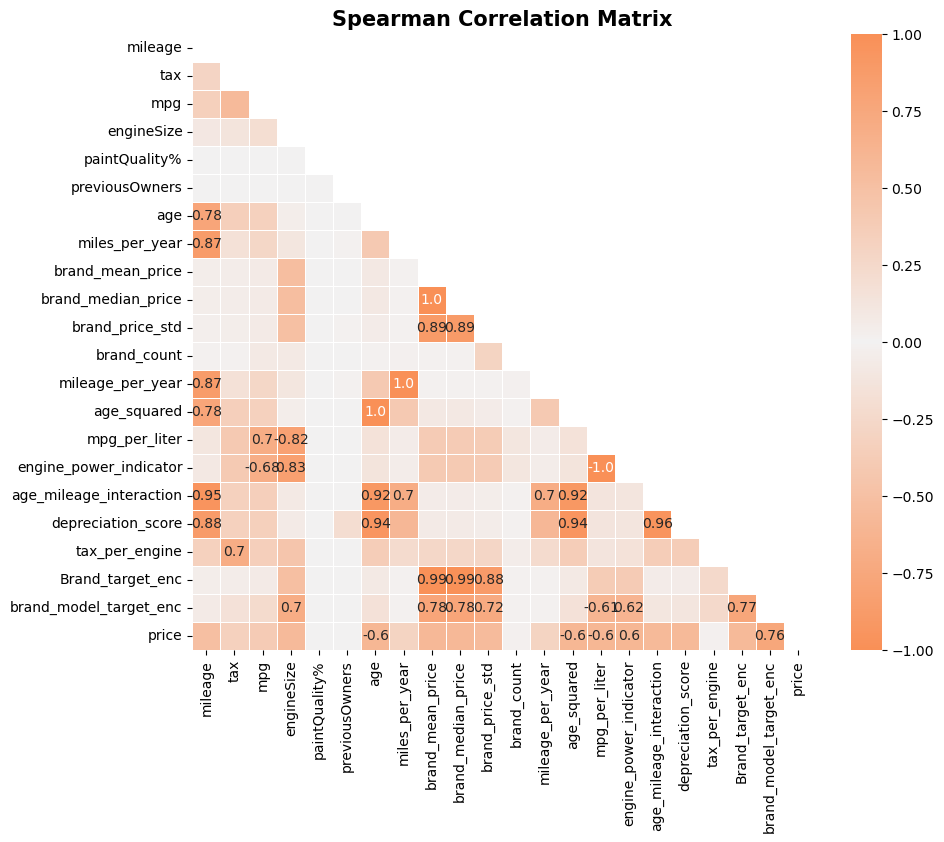

In [25]:
##### Spearman Correlation ####
cor = pd.concat([X_train_filtered, y_train], axis=1).corr(method='spearman').round(2)

# Create a custom diverging colormap based on orange tones
cmap = sns.diverging_palette(h_neg=30, h_pos=30, s=90, l=70, n=256, center="light", as_cmap=True) 

# Create a Mask to hide the upper triangle (to avoid redundancy)
mask = np.zeros_like(cor, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Only show values where absolute correlation is >= 0.6
mask_annot = np.absolute(cor.values) >= 0.6
annot = np.where(mask_annot, cor.values, np.full(cor.shape, ""))

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(
    data=cor,
    mask=mask,              # Hide the upper triangle
    cmap=cmap,              # Custom divergent color map
    annot=annot,            # Show annotations only if |value| >= 0.6
    fmt='s',                # Format annotations as strings
    vmin=-1, vmax=1, center=0, # Ensure the scale is from -1 to 1, centered at 0
    linewidths=0.5, 
)

plt.title('Spearman Correlation Matrix', fontsize=15, fontweight='bold')
plt.show()

By the rule of thumb, two variables are considered **redundant** when their absolute correlation is **greater than or equal to 0.8**. This is the case for **`mileage`** and **`miles_per_year`**, which is expected since `miles_per_year` was derived from `mileage`. We believe it would make more sense to **drop `mileage`**, as `miles_per_year` captures more information and `mileage` is also **highly correlated with `age`**, which could lead to **multicollinearity issues** if kept in the model, but we will **postpone this decision until the end of the feature selection stage**, after reviewing all method results.


In [26]:
target_col = y_train.name  # normalmente 'price'

# correlação de cada coluna com o target
cor_with_target = cor[target_col]

# features com |corr| < 0.1
low_corr_features = cor_with_target[cor_with_target.abs() < 0.1]

if not low_corr_features.empty:
    print(f"Found {len(low_corr_features)} variables with absolute correlation < 0.1 with {target_col}:")
    print(low_corr_features.abs().sort_values())
else:
    print(f"No variables found with absolute correlation < 0.1 with the target")

low_corr_to_drop = set(low_corr_features.index.tolist())


Found 4 variables with absolute correlation < 0.1 with price:
paintQuality%     0.00
previousOwners    0.00
brand_count       0.02
tax_per_engine    0.02
Name: price, dtype: float64


In [27]:
# só features (tudo menos o target)
feature_cols = [c for c in cor.columns if c != target_col]

# correlação absoluta entre features
corr_features = cor.loc[feature_cols, feature_cols].abs()

# parte superior da matriz para não repetir pares
upper = corr_features.where(np.triu(np.ones(corr_features.shape), k=1).astype(bool))

high_corr_threshold = 0.8  # ajusta se quiseres

high_corr_pairs = []
for col in upper.columns:
    for row, val in upper[col].dropna().items():
        if val > high_corr_threshold:
            high_corr_pairs.append((row, col, val))

print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs with |corr| > {high_corr_threshold}:")
for f1, f2, v in high_corr_pairs:
    print(f"  {f1}  <->  {f2}   (corr = {v:.2f})")

# decidir qual remover em cada par
high_corr_to_drop = set()

for f1, f2, v in high_corr_pairs:
    corr_f1_target = abs(cor.loc[f1, target_col])
    corr_f2_target = abs(cor.loc[f2, target_col])

    # 👉 manter a que tem MAIOR |corr| com o target
    # logo, deitamos fora a que tem MENOR |corr| com o target
    if corr_f1_target < corr_f2_target:
        high_corr_to_drop.add(f1)
    else:
        high_corr_to_drop.add(f2)

if high_corr_to_drop:
    print(f"\nBased on high inter-feature correlation, will drop {len(high_corr_to_drop)} features (keeping the one with higher |corr| to target):")
    for f in sorted(high_corr_to_drop):
        print("  -", f)
else:
    print("\nNo features to drop based on high inter-feature correlation.")



Found 20 highly correlated feature pairs with |corr| > 0.8:
  mileage  <->  miles_per_year   (corr = 0.87)
  brand_mean_price  <->  brand_median_price   (corr = 1.00)
  brand_mean_price  <->  brand_price_std   (corr = 0.89)
  brand_median_price  <->  brand_price_std   (corr = 0.89)
  mileage  <->  mileage_per_year   (corr = 0.87)
  miles_per_year  <->  mileage_per_year   (corr = 1.00)
  age  <->  age_squared   (corr = 1.00)
  engineSize  <->  mpg_per_liter   (corr = 0.82)
  engineSize  <->  engine_power_indicator   (corr = 0.83)
  mpg_per_liter  <->  engine_power_indicator   (corr = 1.00)
  mileage  <->  age_mileage_interaction   (corr = 0.95)
  age  <->  age_mileage_interaction   (corr = 0.92)
  age_squared  <->  age_mileage_interaction   (corr = 0.92)
  mileage  <->  depreciation_score   (corr = 0.88)
  age  <->  depreciation_score   (corr = 0.94)
  age_squared  <->  depreciation_score   (corr = 0.94)
  age_mileage_interaction  <->  depreciation_score   (corr = 0.96)
  brand_mean_pr

  estamos a criar a mesma variavei duas vezes miles_per_year  <->  mileage_per_year   (corr = 1.00)

In [28]:
features_to_drop = sorted(low_corr_to_drop | high_corr_to_drop)

print(f"\nTotal features to drop (low corr with target + high inter-feature corr): {len(features_to_drop)}")
print(features_to_drop)

X_train_clean = X_train.drop(columns=features_to_drop)
X_val_clean   = X_val.drop(columns=features_to_drop)
X_test_clean  = X_test.drop(columns=features_to_drop)

print("\nShapes after feature filtering:")
print("X_train_clean:", X_train_clean.shape)
print("X_val_clean:  ", X_val_clean.shape)
print("X_test_clean: ", X_test_clean.shape)



Total features to drop (low corr with target + high inter-feature corr): 15
['Brand_target_enc', 'age_mileage_interaction', 'age_squared', 'brand_count', 'brand_median_price', 'brand_price_std', 'depreciation_score', 'engineSize', 'engine_power_indicator', 'mileage', 'mileage_per_year', 'miles_per_year', 'paintQuality%', 'previousOwners', 'tax_per_engine']

Shapes after feature filtering:
X_train_clean: (60763, 21)
X_val_clean:   (15193, 21)
X_test_clean:  (32567, 21)


Generic

Remover variaveis inuteis com lasso

In [29]:
lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
lasso.fit(X_train_clean, y_train)

# Guardar apenas as features com coeficiente diferente de 0
selected_features = X_train_clean.columns[lasso.coef_ != 0].tolist()

print(f"Selecionadas {len(selected_features)} features via Lasso.")

Selecionadas 21 features via Lasso.


In [30]:
X_train_lasso = X_train_clean[selected_features]
X_val_lasso   = X_val_clean[selected_features]
X_test_lasso  = X_test_clean[selected_features]

In [32]:
X_train_lasso.columns

Index(['tax', 'mpg', 'age', 'brand_mean_price', 'high_mileage', 'low_mileage',
       'is_new_car', 'is_old_car', 'mpg_per_liter', 'brand_model_target_enc',
       'transmission_manual', 'transmission_other', 'transmission_semi auto',
       'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid',
       'fuelType_other', 'fuelType_petrol', 'fuelType_unknown',
       'brand_segment_luxury', 'brand_segment_mid_range'],
      dtype='object')

## Gradiant Booster

RFE específico para Gradient Boosting (usando a tua função)

Aqui usas exatamente a tua função para escolher o nº ótimo de features para o Gradient Boosting.

In [31]:
# Modelo base para o RFE
gbr_base = GradientBoostingRegressor(random_state=42)

rfe_results_gbr = find_optimal_features_rfe(
    model=gbr_base,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

gbr_optimal_n = rfe_results_gbr["optimal_n"]
gbr_best_val_mae = rfe_results_gbr["best_score"]
gbr_features = rfe_results_gbr["selected_features"]

print("\n[GBR-RFE] nº ótimo de features:", gbr_optimal_n)
print("[GBR-RFE] melhor MAE no validation durante RFE:", gbr_best_val_mae)
print("[GBR-RFE] Features selecionadas:")
for f in gbr_features:
    print("  -", f)


Running RFE with model: GradientBoostingRegressor


KeyboardInterrupt: 

In [ ]:
gbr_train_maes = rfe_results_gbr["train_scores"]
gbr_val_maes   = rfe_results_gbr["val_scores"]

Construir os datasets só com as features do GBR

In [ ]:
X_train_gbr = X_train[gbr_features].copy()
X_val_gbr   = X_val[gbr_features].copy()
X_test_gbr  = X_test[gbr_features].copy()

# Para treino final em train+val
X_trainval_gbr = pd.concat([X_train_gbr, X_val_gbr], axis=0)
y_trainval_gbr = pd.concat([y_train,    y_val],    axis=0)

Definir o objective do Optuna para Gradient Boosting

In [ ]:
def objective_gbr(trial):
    # 1) Hiperparâmetros a explorar
    n_estimators = trial.suggest_int("n_estimators", 100, 400)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    subsample = trial.suggest_float("subsample", 0.6, 1.0)
    max_features = trial.suggest_categorical("max_features", [None, "sqrt", 0.5, 0.8])

    model = GradientBoostingRegressor(
        random_state=42,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
    )

    # 2) Cross-validation só no TRAIN (val fica guardado para mais tarde)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    maes = []

    for train_idx, val_idx in kf.split(X_train_gbr):
        X_tr, X_cv = X_train_gbr.iloc[train_idx], X_train_gbr.iloc[val_idx]
        y_tr, y_cv = y_train.iloc[train_idx],    y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_cv_pred = model.predict(X_cv)
        mae = mean_absolute_error(y_cv, y_cv_pred)
        maes.append(mae)

    return float(np.mean(maes))


Correr o Optuna (encontrar os melhores hiperparâmetros)

In [ ]:
study_gbr = optuna.create_study(
    direction="minimize",
    study_name="GBR_Optuna"
)

study_gbr.optimize(
    objective_gbr,
    n_trials=50,            # podes aumentar/diminuir conforme o tempo
    show_progress_bar=True
)

print("\n[Optuna-GBR] Melhor MAE (CV):", study_gbr.best_value)
print("[Optuna-GBR] Melhores hiperparâmetros:")
for k, v in study_gbr.best_trial.params.items():
    print(f"  {k}: {v}")


In [ ]:
gbr_trials_df = study_gbr.trials_dataframe()


Treinar o modelo final e avaliar no validation

Aqui já não há CV, é:
treinar em X_train_gbr → avaliar em X_val_gbr para ter um MAE “limpo”.

In [ ]:
best_params_gbr = study_gbr.best_trial.params

best_gbr = GradientBoostingRegressor(
    random_state=42,
    **best_params_gbr
)

# Treino só com TRAIN
best_gbr.fit(X_train_gbr, y_train)

# MAE no validation
y_val_pred_gbr = best_gbr.predict(X_val_gbr)
val_mae_gbr = mean_absolute_error(y_val, y_val_pred_gbr)
print(f"\n[GBR + Optuna] MAE no validation set: {val_mae_gbr:.4f}")


Modelo final em train+val + feature importance

Para o modelo que vais usar para Kaggle:

In [ ]:
best_gbr_final = GradientBoostingRegressor(
    random_state=42,
    **best_params_gbr
)

best_gbr_final.fit(X_trainval_gbr, y_trainval_gbr)


In [ ]:
gbr_importances = pd.Series(
    best_gbr_final.feature_importances_,
    index=gbr_features
).sort_values(ascending=False)

print("\n[GBR + Optuna] Feature importances (ordenadas):")
print(gbr_importances)


NameError: name 'best_gbr_final' is not defined

In [ ]:
plt.figure(figsize=(8, 5))
gbr_importances.head(15).plot(kind="bar")
plt.title("Gradient Boosting (Optuna) - Top 15 Feature Importances")
plt.tight_layout()
plt.show()


NameError: name 'gbr_importances' is not defined

<Figure size 800x500 with 0 Axes>

Previsões no test + submissão Kaggle

Assumindo que tens o sample_submission.csv com colunas carID e price:

In [ ]:
# 1) Previsões no test
test_preds_gbr = best_gbr_final.predict(X_test_gbr)

# 2) Carregar sample submission
sample_sub = pd.read_csv("./project_data/sample_submission.csv")

# 3) Criar ficheiro de submissão
submission_gbr = sample_sub.copy()
submission_gbr["price"] = test_preds_gbr

submission_gbr.to_csv("submission_gbr_optuna.csv", index=False)
print("Guardado: submission_gbr_optuna.csv")
